## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer

import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
import re, string, unicodedata

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import nltk

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize

In [1046]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Carga de los datos

In [1047]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [1048]:
datos.shape

(1000, 23)

In [1049]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [1050]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
498,1,1,46,3,2,"pain, arm",1,1,6,176.0,...,36.0,NaN,4,Contusion of forearm,1,4,0,46,"4,63",0
606,1,2,64,4,1,fever,3,0,#BOÞ!,100.0,...,36.9,NaN,3,Nosocomial pneumonia,2,3,0,1229,"15,02",0
823,2,1,79,4,1,blood tinged sputum,1,0,#BOÞ!,130.0,...,36.4,74.0,2,Haemoptysis,6,2,0,9378,"5,00",0
194,2,1,29,3,1,right lower abdominal pain,1,1,3,110.0,...,36.1,98.0,4,Unspecified abdominal pain,1,4,0,755,"5,00",0
389,1,1,57,3,2,facial injury,1,1,4,158.0,...,36.7,NaN,4,Laceration of oral cavity,1,4,0,113,"5,52",0


## 2. Entendimiento de los datos

Variables numericas candidatas a utilizar

In [1051]:
candidatas = ["Grupo","Lesion","KTAS_experto","Duracion_KTAS_Min","EWS"]
numericas=["Grupo", "Sexo", "Edad", "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor", "dolor_NRS", "KTAS_enfermera", "Disposicion", "KTAS_experto", "Duracion_Estancia_Min", "Duracion_KTAS_Min"]

In [1052]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [1053]:
datos["Sexo"].value_counts()


Sexo
2    514
1    486
Name: count, dtype: int64

In [1054]:
datos["dolor_NRS"].value_counts()

dolor_NRS
#BOÞ!    440
3        209
4        111
5        109
6         59
2         31
7         27
8          8
10         3
1          2
9          1
Name: count, dtype: int64

In [1055]:
datos["Error_Triaje"].value_counts()

Error_Triaje
0    851
2    104
1     45
Name: count, dtype: int64

In [1056]:
datos["Modo_Llegada"].value_counts()

Modo_Llegada
3    588
2    220
4    122
1     60
6      7
5      2
7      1
Name: count, dtype: int64

In [1057]:
datos["Grupo_De_Error"].value_counts().sort_index()


Grupo_De_Error
0    851
1     16
2     39
3      6
4     50
5     11
6      6
7      7
8      9
9      5
Name: count, dtype: int64

In [1058]:
datos["Queja_Principal"].value_counts().sort_index()

Queja_Principal
??                       5
?? ??                    1
?? ???                   2
?? ??? ??                1
???                      3
                        ..
weakness                 1
whirling type vertigo    3
wrist laceration         1
wrist pain, Lt           1
wrist pain, Rt           1
Name: count, Length: 347, dtype: int64

In [1059]:
"""datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a[a["Error_Triaje"]==1]
plt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])"""


'datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]\na = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]\na[a["Error_Triaje"]==1]\nplt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])'

In [1060]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 2
    elif 9 <= registro['RR'] <= 14:
        total += 0
    elif 15 <= registro['RR'] <= 20:
        total += 1
    elif 21 <= registro['RR'] <= 29:
        total += 2
    elif registro['RR'] >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 70:
        total += 3
    elif 71 <= registro['SBP'] <= 80:
        total += 2
    elif 81 <= registro['SBP'] <= 100:
        total += 1
    elif 101 <= registro['SBP'] <= 199:
        total += 0
    elif registro['SBP'] >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 2
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 51 <= registro['HR'] <= 100:
        total += 0
    elif 101 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 129:
        total += 2
    elif registro['HR'] >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 2
    elif 35.0 <= registro['BT'] <= 38.4:
        total += 0
    elif 38.5 <= registro['BT']:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro['Saturacion'] <= 91:
        total += 3
    elif 92 <= registro['Saturacion'] <= 93:
        total += 2
    elif 94 <= registro['Saturacion'] <= 95:
        total += 1

    # Nivel de conciencia
    if registro['Estado_Mental'] == 1:
        total += 0
    elif registro['Estado_Mental'] == 2:
        total += 1
    elif registro['Estado_Mental'] == 3:
        total += 2
    elif registro['Estado_Mental'] == 4:
        total += 3
    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
print(datos.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...  Saturacion  KTAS_enfermera  \
0      1         2  150.0  ...        98.0               2   
1      1         4  140.0  ...        99.0               3   
2      1         3  100.0  ...        98.0               4   
3      1         4  120.0  ...        99.0               4   
4      0     #BOÞ!  143.0  ...         NaN               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain            2             2   
1  Subarachnoid 

In [1061]:
datos.sample(10)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
505,2,1,49,3,2,Open Wound,1,1,3,120.0,...,98.0,4,"Open wound of other parts of head, face",1,4,0,134,"2,00",0,1
584,1,1,61,3,2,Lt. hip joint pain,1,1,5,146.0,...,NaN,4,Contusion of hip,1,4,0,51,"6,62",0,2
593,2,1,70,4,1,melena,1,0,#BOÞ!,130.0,...,99.0,3,"Gastrointestinal haemorrhage, unspecified",1,3,0,829,"4,00",0,1
450,1,2,41,1,2,FB in esophagus,1,0,#BOÞ!,126.0,...,NaN,4,Foreign body in throat food,1,4,0,59,"4,15",0,1
810,2,1,16,3,1,nausea,1,1,3,110.0,...,97.0,4,Unspecified abdominal pain,2,4,0,8961,"2,00",0,3
782,1,2,49,3,2,finger laceration,1,0,#BOÞ!,142.0,...,NaN,4,Laceration of finger without nail damage,1,4,0,48,"6,95",0,2
568,1,1,28,3,1,dyspnea,1,0,#BOÞ!,142.0,...,NaN,4,Chronic urticaria,1,3,1,228,"11,38",2,1
166,2,2,53,3,1,hematemesis,1,0,#BOÞ!,130.0,...,99.0,3,"Gastrointestinal haemorrhage, unspecified",2,3,0,426,"5,00",0,1
849,1,1,73,3,1,"Discomfort, Chest",1,0,#BOÞ!,119.0,...,NaN,2,Bradycardia,3,2,0,312,"11,65",0,3
198,2,2,50,4,1,abd pain,1,1,4,120.0,...,98.0,3,"Cholecystitis with cholelithiasis NOS, With ob...",7,3,0,435,"2,00",0,1


Análisis de completitud

In [1062]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
EWS                         0.000
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

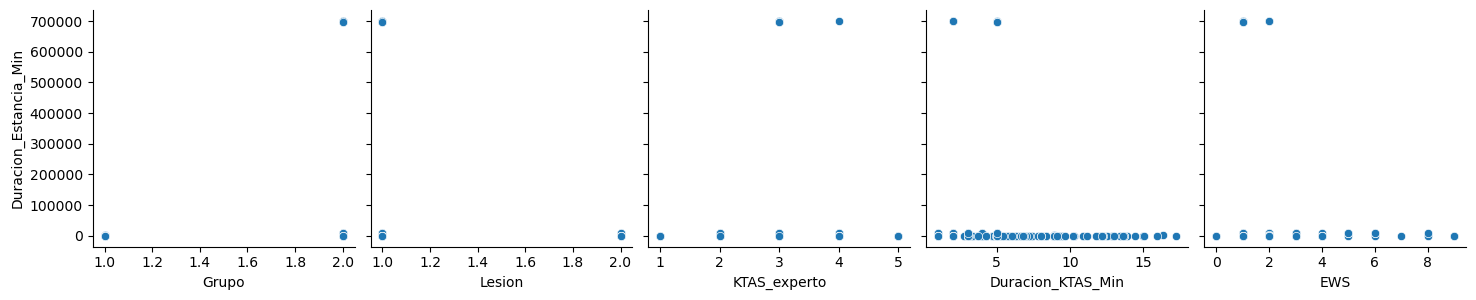

In [1063]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=candidatas, kind="scatter")

In [1064]:
"""for variable in candidatas:
    sns.pairplot(datos, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")"""

'for variable in candidatas:\n    sns.pairplot(datos, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")'

In [1065]:
datos["Modo_Llegada"] = datos["Modo_Llegada"].apply(lambda x: 1 if x == 1 else (2 if x == 2 or x ==4 else (3 if x == 3 else 4)))


In [1066]:
"""prueba=datos[datos["Duracion_Estancia_Min"]<=4000]
for variable in candidatas:
    sns.pairplot(prueba, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")"""

'prueba=datos[datos["Duracion_Estancia_Min"]<=4000]\nfor variable in candidatas:\n    sns.pairplot(prueba, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")'

In [1067]:
"""for variable in numericas:
    plt.hist(prueba[variable], bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histograma de ' + variable)
    plt.xlabel(variable)
    plt.ylabel('Duracion')
    plt.show()"""

"for variable in numericas:\n    plt.hist(prueba[variable], bins=30, edgecolor='k', alpha=0.7)\n    plt.title('Histograma de ' + variable)\n    plt.xlabel(variable)\n    plt.ylabel('Duracion')\n    plt.show()"

In [1068]:
"""candidatas2=candidatas+["Duracion_Estancia_Min"]
fig, ax = plt.subplots(len(candidatas2), 1, layout="constrained", figsize=(3,30))
for i in range(len(candidatas2)):
    ax[i].boxplot(prueba[candidatas2[i]])
    ax[i].set_title(candidatas2[i])"""

'candidatas2=candidatas+["Duracion_Estancia_Min"]\nfig, ax = plt.subplots(len(candidatas2), 1, layout="constrained", figsize=(3,30))\nfor i in range(len(candidatas2)):\n    ax[i].boxplot(prueba[candidatas2[i]])\n    ax[i].set_title(candidatas2[i])'

<Axes: xlabel='Duracion_Estancia_Min'>

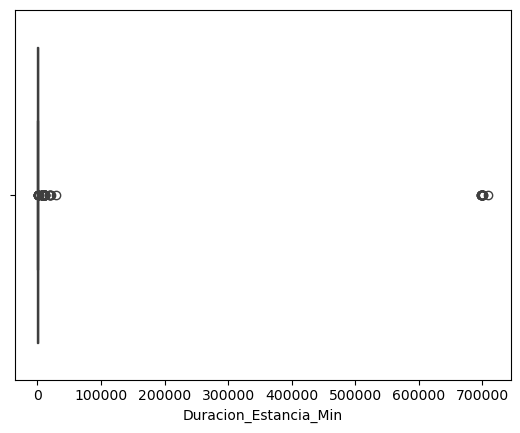

In [1069]:
sns.boxplot(datos, x="Duracion_Estancia_Min")

(849, 24)

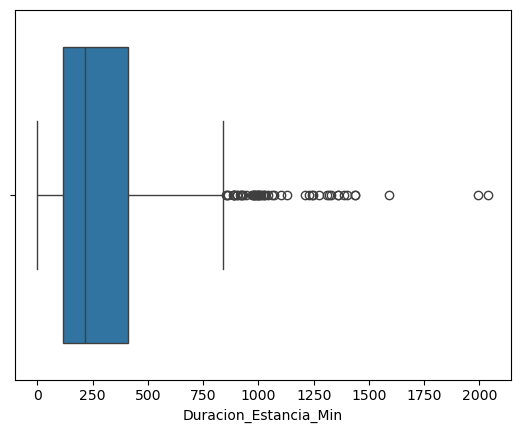

In [1070]:

sns.boxplot(prueba, x="Duracion_Estancia_Min")
prueba.shape

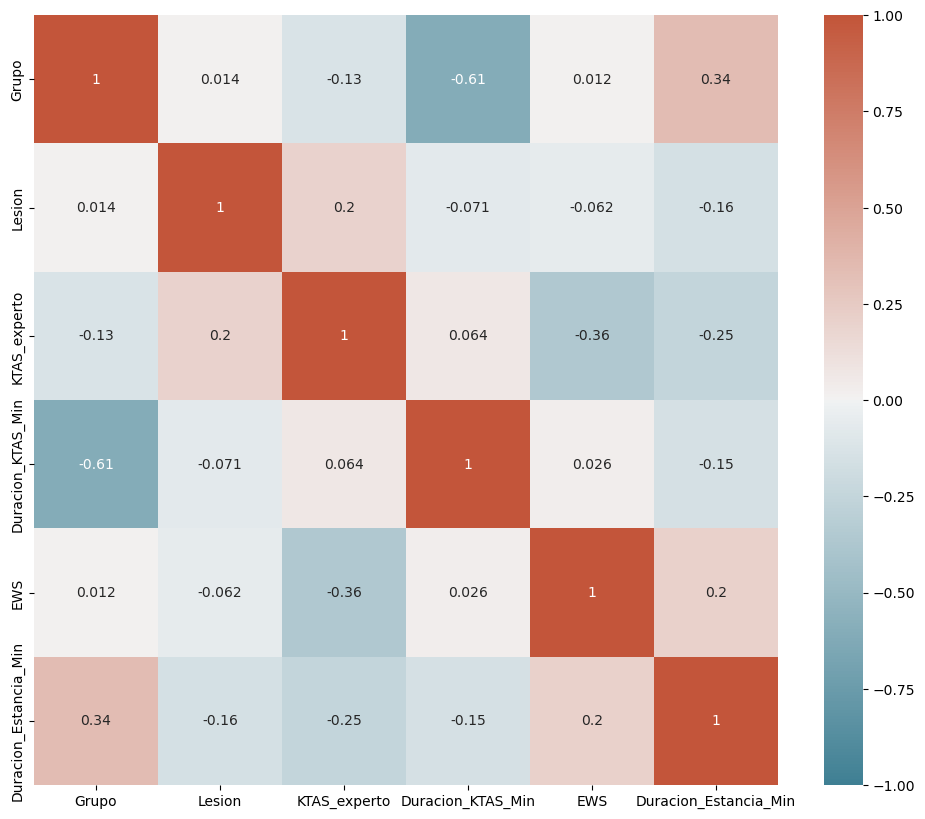

In [1071]:
plt.figure(figsize=(12, 10))
# Crear una paleta de colores divergente con el color blanco en el centro
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Crear el heatmap con la paleta personalizada
sns.heatmap(
    prueba[candidatas + ['Duracion_Estancia_Min']].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

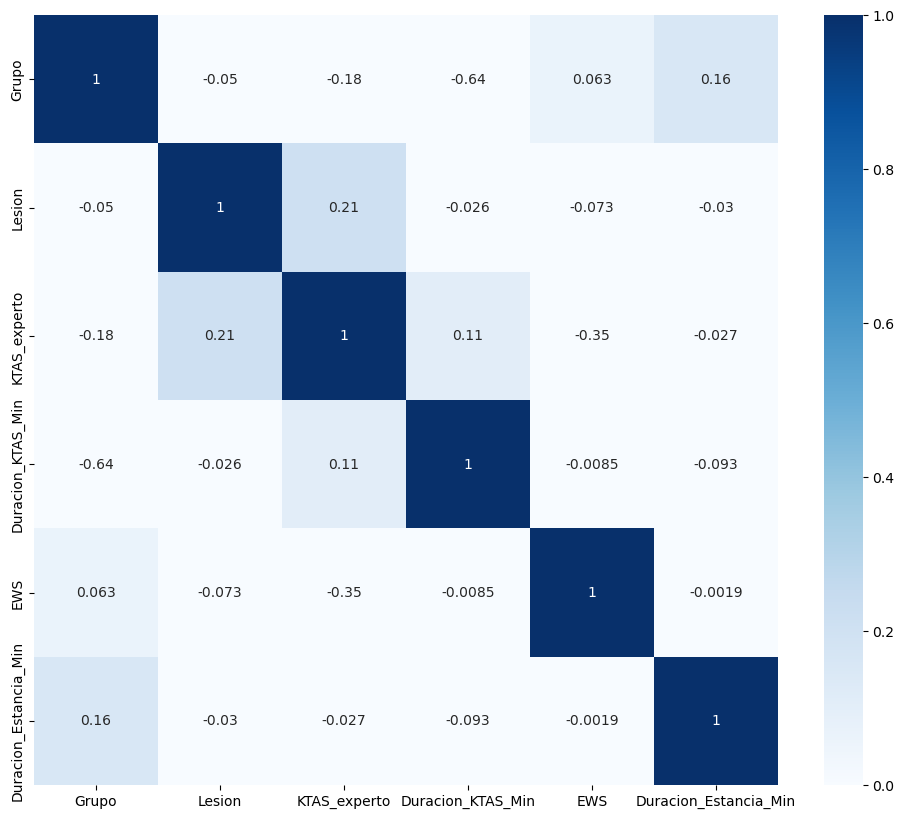

In [1072]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

## 3. Preparación de datos

In [1073]:
datos=datos[datos["Duracion_Estancia_Min"]<=850]
datos["Disposicion"]=datos["Disposicion"]/7
datos["KTAS_experto"]=datos["KTAS_experto"]/5
datos["Estado_Mental"]=datos["Estado_Mental"]/4

### 3.1. Relacionado con la calidad de los datos

In [1074]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [1075]:
datos.shape
total_rows = datos.shape[0]
total_rows

798

In [1076]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Lesion                   0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
dtype: float64

In [1077]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Lesion                   0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
dtype: float64

In [1078]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,99.0,3,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.0,0,1
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,98.0,4,Contusion of front wall of thorax,0.142857,0.8,0,119,2.0,0,2
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,99.0,4,Headache,0.142857,0.6,4,414,2.0,2,1
9,2,2,27,2,1,LLQ pain,0.25,1,3,130.0,...,97.0,4,Unspecified abdominal pain,0.142857,0.8,0,493,2.0,0,1
12,2,2,69,3,1,dyspnea,0.25,0,#BOÞ!,100.0,...,99.0,3,"Pleural effusion, NEC",0.285714,0.6,0,415,4.0,0,2


In [1079]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

330

In [1080]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 41.3534%


In [1081]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
996,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,110.0,...,NaN,3,Suicide tendency,0.285714,0.6,0,442,7.42,0,1
997,1,2,54,2,1,"pain, chest",0.25,1,6,159.0,...,NaN,2,Gastroesophageal reflux disease,0.142857,0.4,0,214,4.95,0,1
998,1,1,19,3,1,eye discomfort,0.25,0,#BOÞ!,132.0,...,NaN,4,Corneal erosion,0.142857,0.8,0,50,3.45,0,1
999,1,2,29,3,1,"pain, abdominal",0.25,1,6,137.0,...,NaN,3,Allergic reaction,0.142857,0.6,0,116,5.97,0,1


In [1082]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

65

In [1083]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 8.1454%


In [1084]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [1085]:
datos.shape

(559, 24)

Train: 155.45751459485078
Test: 178.00277092711974


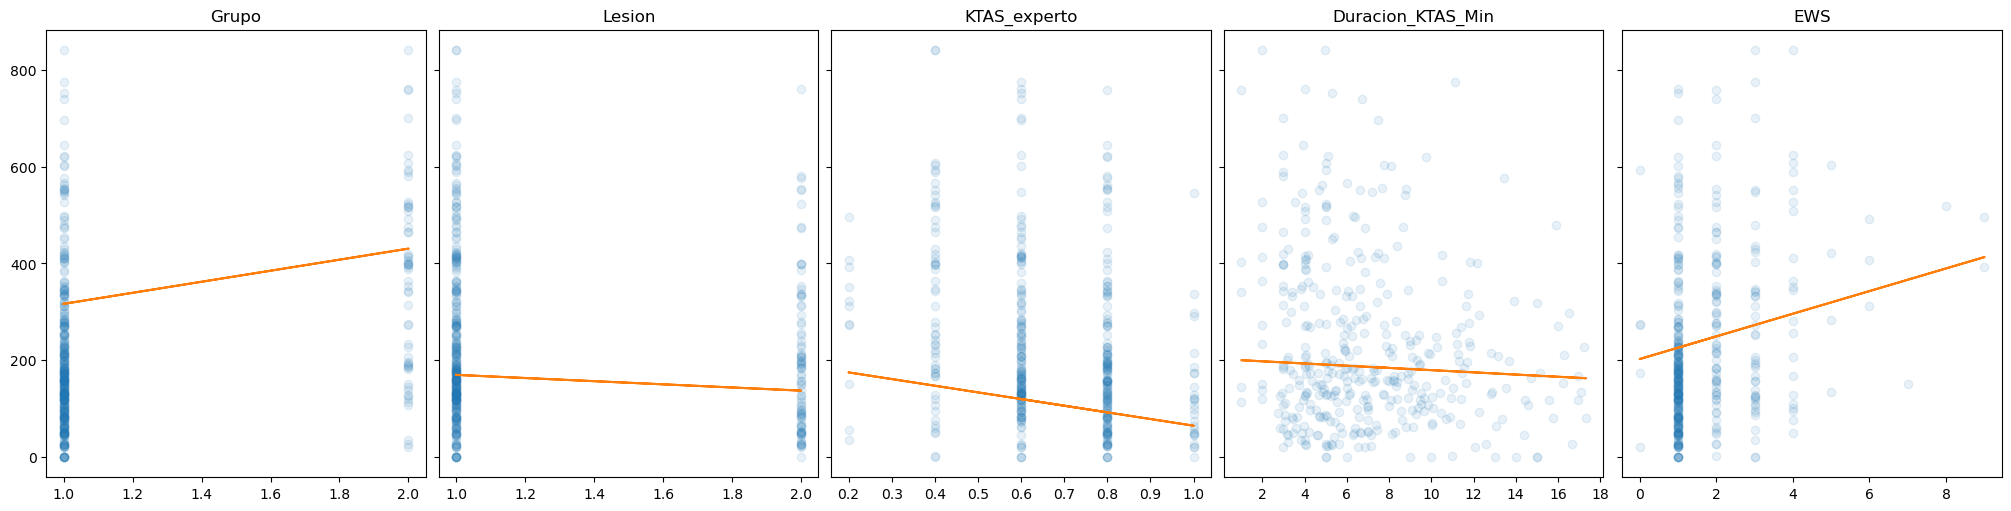

In [1086]:
X_train, X_test, y_train, y_test = train_test_split(datos[candidatas], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))


In [1087]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
306,2,2,78,2,1,G/W-General weakness,0.25,0,#BOÞ!,80.0,...,95.0,2,Ventricular tachycardia,0.285714,0.4,0,589,3.00,0,4
271,1,2,71,1,1,voiding difficulty,0.25,0,#BOÞ!,152.0,...,NaN,4,Benign prostatic hyperplasia with obstruction,0.142857,0.8,0,47,8.12,0,2
786,1,2,55,1,1,Urticarial rash,0.25,1,1,196.0,...,NaN,5,Allergic urticaria,0.142857,1.0,0,122,9.65,0,1
816,1,2,43,2,1,headache,0.25,1,3,148.0,...,NaN,4,Headache,0.142857,0.8,0,34,8.87,0,2
173,1,1,42,3,1,"bleeding, knee",0.25,1,3,129.0,...,NaN,3,Hemangioma of knee,0.142857,0.6,0,61,9.13,0,1


# Procesamiento de texto

In [1088]:
datos['Queja_Principal'].info()

<class 'pandas.core.series.Series'>
Index: 559 entries, 1 to 965
Series name: Queja_Principal
Non-Null Count  Dtype 
--------------  ----- 
559 non-null    object
dtypes: object(1)
memory usage: 8.7+ KB


In [1089]:
textos = datos.copy()
textos['Conteo'] = [len(x) for x in textos['Queja_Principal']]
#textos['Moda'] =
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]


In [1090]:
textos

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,Conteo,Max,Min
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,1.000000,0.6,0,211,3.00,0,1,8,8,8
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,0.142857,0.8,0,119,2.00,0,2,15,5,4
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,0.142857,0.6,4,414,2.00,2,1,8,8,8
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,0.142857,0.4,1,267,3.60,2,4,13,5,1
6,1,1,74,3,1,abd pain,0.25,1,6,118.0,...,0.142857,0.6,0,56,8.72,0,1,8,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,110.0,...,0.285714,0.6,0,442,7.42,0,1,16,8,7
956,1,1,74,2,1,Seizure Like Activity,0.25,0,#BOÞ!,161.0,...,0.142857,0.6,0,173,4.28,0,0,21,8,4
957,1,2,27,3,2,"pain, low back",0.25,1,4,136.0,...,0.142857,0.6,9,26,5.63,2,1,14,5,3
961,1,2,48,2,1,dyspnea,0.25,0,#BOÞ!,NaN,...,0.142857,0.2,1,272,4.10,2,0,7,7,7


In [1091]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word:  # Verifica que la palabra no sea None o una cadena vacía
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = [word.lower() for word in words if word]  # Usa comprensión de listas
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = [re.sub(r'[^\w\s]', '', word) for word in words if word]  # Usa comprensión de listas
    return [word for word in new_words if word]

#def replace_numbers(words):
#    """Replace all interger occurrences in list of tokenized words with textual representation"""
#    p = inflect.engine()
#    print(words)
#    new_words = []
#    for word in words:
#        if word.isdigit():
#            new_word = p.number_to_words(word)
#            new_words.append(new_word)
#            print("if " + new_word)
#        else:
#            new_words.append(word)
#    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('english'))  # Usa un set para búsquedas más rápidas
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

def preprocessing(words):
    words = to_lowercase(words)
#   words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [1092]:
datos['Queja_Principal'] = datos['Queja_Principal'].apply(contractions.fix)

In [1093]:
datos['words'] = datos['Queja_Principal'].apply(word_tokenize)
datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,3,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.00,0,1,[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,4,Contusion of front wall of thorax,0.142857,0.8,0,119,2.00,0,2,"[ant, ., chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,4,Headache,0.142857,0.6,4,414,2.00,2,1,[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,4,Fever,0.142857,0.4,1,267,3.60,2,4,"[fever, &, chill]"
6,1,1,74,3,1,abd pain,0.25,1,6,118.0,...,3,Parkinsonism,0.142857,0.6,0,56,8.72,0,1,"[abd, pain]"


In [1094]:
datos['words'].dropna()

1                     [headache]
2          [ant, ., chest, pain]
3                     [headache]
4              [fever, &, chill]
6                    [abd, pain]
                 ...            
955          [Suicidal, Attempt]
956    [Seizure, Like, Activity]
957         [pain, ,, low, back]
961                    [dyspnea]
965           [sexual, violence]
Name: words, Length: 559, dtype: object

In [1095]:
datos.shape

(559, 25)

In [1096]:
datos['words'].info()

<class 'pandas.core.series.Series'>
Index: 559 entries, 1 to 965
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
559 non-null    object
dtypes: object(1)
memory usage: 8.7+ KB


In [1097]:
datos['words1']=datos['words'].apply(preprocessing)

datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.00,0,1,[headache],[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,Contusion of front wall of thorax,0.142857,0.8,0,119,2.00,0,2,"[ant, ., chest, pain]","[ant, chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,Headache,0.142857,0.6,4,414,2.00,2,1,[headache],[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,Fever,0.142857,0.4,1,267,3.60,2,4,"[fever, &, chill]","[fever, chill]"
6,1,1,74,3,1,abd pain,0.25,1,6,118.0,...,Parkinsonism,0.142857,0.6,0,56,8.72,0,1,"[abd, pain]","[abd, pain]"


In [1098]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = [stemmer.stem(word) for word in words]
    return stems
    

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lems = [lemmatizer.lemmatize(word) for word in words]
    return lems

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

datos['words'] = datos['words1'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
datos

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.00,0,1,"[headach, headache]",[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,Contusion of front wall of thorax,0.142857,0.8,0,119,2.00,0,2,"[ant, chest, pain, ant, chest, pain]","[ant, chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,Headache,0.142857,0.6,4,414,2.00,2,1,"[headach, headache]",[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,Fever,0.142857,0.4,1,267,3.60,2,4,"[fev, chil, fever, chill]","[fever, chill]"
6,1,1,74,3,1,abd pain,0.25,1,6,118.0,...,Parkinsonism,0.142857,0.6,0,56,8.72,0,1,"[abd, pain, abd, pain]","[abd, pain]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,110.0,...,Suicide tendency,0.285714,0.6,0,442,7.42,0,1,"[suicid, attempt, suicidal, attempt]","[suicidal, attempt]"
956,1,1,74,2,1,Seizure Like Activity,0.25,0,#BOÞ!,161.0,...,Vasovagal syncope,0.142857,0.6,0,173,4.28,0,0,"[seiz, lik, act, seizure, like, activity]","[seizure, like, activity]"
957,1,2,27,3,2,"pain, low back",0.25,1,4,136.0,...,Sprain of cervical spine,0.142857,0.6,9,26,5.63,2,1,"[pain, low, back, pain, low, back]","[pain, low, back]"
961,1,2,48,2,1,dyspnea,0.25,0,#BOÞ!,NaN,...,Dyspnea,0.142857,0.2,1,272,4.10,2,0,"[dyspne, dyspnea]",[dyspnea]


In [1099]:
datos['words'] = datos['words1'].apply(lambda x: ' '.join(map(str, x)))
datos

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1
1,2,2,30,2,1,headache,0.25,1,4,140.0,...,"Subarachnoid haemorrhage, unspecified",1.000000,0.6,0,211,3.00,0,1,headache,[headache]
2,2,1,61,3,2,ant. chest pain,0.25,1,3,100.0,...,Contusion of front wall of thorax,0.142857,0.8,0,119,2.00,0,2,ant chest pain,"[ant, chest, pain]"
3,2,2,61,3,1,headache,0.25,1,4,120.0,...,Headache,0.142857,0.6,4,414,2.00,2,1,headache,[headache]
4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,143.0,...,Fever,0.142857,0.4,1,267,3.60,2,4,fever chill,"[fever, chill]"
6,1,1,74,3,1,abd pain,0.25,1,6,118.0,...,Parkinsonism,0.142857,0.6,0,56,8.72,0,1,abd pain,"[abd, pain]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,110.0,...,Suicide tendency,0.285714,0.6,0,442,7.42,0,1,suicidal attempt,"[suicidal, attempt]"
956,1,1,74,2,1,Seizure Like Activity,0.25,0,#BOÞ!,161.0,...,Vasovagal syncope,0.142857,0.6,0,173,4.28,0,0,seizure like activity,"[seizure, like, activity]"
957,1,2,27,3,2,"pain, low back",0.25,1,4,136.0,...,Sprain of cervical spine,0.142857,0.6,9,26,5.63,2,1,pain low back,"[pain, low, back]"
961,1,2,48,2,1,dyspnea,0.25,0,#BOÞ!,NaN,...,Dyspnea,0.142857,0.2,1,272,4.10,2,0,dyspnea,[dyspnea]


In [1100]:
X_data, y_data = datos['words'],datos['Edad']
y_data
X_data

1                   headache
2             ant chest pain
3                   headache
4                fever chill
6                   abd pain
               ...          
955         suicidal attempt
956    seizure like activity
957            pain low back
961                  dyspnea
965          sexual violence
Name: words, Length: 559, dtype: object

In [1101]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)  # X_data es tu lista de textos
print(X_dummy.shape)  # (805, 412)

# Paso 2: Convertir a DataFrame (esto es opcional si solo quieres ver los datos en formato de tabla)
X_dense = X_dummy.toarray()
X_df = pd.DataFrame(X_dense, columns=dummy.get_feature_names_out())

# Paso 3: Aplicar TF-IDF usando TfidfTransformer
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(X_dummy)  # Usa X_dummy directamente

# Paso 4: Convertir a una matriz densa si es necesario para inspección o para usarla en otro proceso
tt_matrix_dense = tt_matrix.toarray()

# Paso 5: Crear DataFrame con la matriz TF-IDF
vocab = dummy.get_feature_names_out()
tt_df = pd.DataFrame(np.round(tt_matrix_dense, 2), columns=vocab)
print(tt_df.sample(1).to_numpy())  # Debe coincidir con (805, 412)



(559, 219)
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.53 0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.62 0.   0.   0.   0.   0.
  0.   0.   0.   0.53 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.23 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.

In [1102]:
X_train, X_test, y_train, y_test = train_test_split(tt_df, y_data, test_size=0.3, random_state=42)

In [1103]:
regressor = LinearRegression()

# Entrenar el modelo
regressor.fit(X_train, y_train)

LinearRegression()

In [1104]:
print("Train:", np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

Train: 15.096520637448695
Test: 593710373283545.4


In [1105]:
coefficients_df = pd.DataFrame({
    "columns": tt_df.columns,  # Nombres de las características (palabras del vocabulario)
    "coef": regressor.coef_   # Coeficientes del modelo de regresión lineal
})

print(coefficients_df)

       columns          coef
0          abd -3.706388e+01
1      abdomen -1.896957e+01
2    abdominal -2.009557e+01
3     abnormal -1.726950e+14
4        abuse -4.900110e+14
..         ...           ...
214   weakness  5.328125e+00
215   whirling  0.000000e+00
216      wound  1.295312e+01
217      wrist -3.851562e+01
218       wyou  0.000000e+00

[219 rows x 2 columns]


In [1106]:
tt_df.max()

abd          0.84
abdomen      0.93
abdominal    0.92
abnormal     0.71
abuse        0.60
             ... 
weakness     1.00
whirling     0.60
wound        0.70
wrist        0.82
wyou         0.71
Length: 219, dtype: float64

In [1107]:
quejas=pd.Series(regressor.predict(tt_df), name = "Quejas")
nuevo=["Quejas"]+candidatas
datos = datos.reset_index()
datos["Quejas"] = quejas
datos


,index,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS,words,words1,Quejas
0,1,2,2,30,2,1,headache,0.25,1,4,...,1.000000,0.6,0,211,3.00,0,1,headache,[headache],5.486547e+01
1,2,2,1,61,3,2,ant. chest pain,0.25,1,3,...,0.142857,0.8,0,119,2.00,0,2,ant chest pain,"[ant, chest, pain]",5.751891e+01
2,3,2,2,61,3,1,headache,0.25,1,4,...,0.142857,0.6,4,414,2.00,2,1,headache,[headache],5.486547e+01
3,4,1,2,67,3,1,fever & chill,0.25,0,#BOÞ!,...,0.142857,0.4,1,267,3.60,2,4,fever chill,"[fever, chill]",6.549047e+01
4,6,1,1,74,3,1,abd pain,0.25,1,6,...,0.142857,0.6,0,56,8.72,0,1,abd pain,"[abd, pain]",4.432869e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,955,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,...,0.285714,0.6,0,442,7.42,0,1,suicidal attempt,"[suicidal, attempt]",4.758422e+01
555,956,1,1,74,2,1,Seizure Like Activity,0.25,0,#BOÞ!,...,0.142857,0.6,0,173,4.28,0,0,seizure like activity,"[seizure, like, activity]",-1.164236e+15
556,957,1,2,27,3,2,"pain, low back",0.25,1,4,...,0.142857,0.6,9,26,5.63,2,1,pain low back,"[pain, low, back]",3.515485e+01
557,961,1,2,48,2,1,dyspnea,0.25,0,#BOÞ!,...,0.142857,0.2,1,272,4.10,2,0,dyspnea,[dyspnea],6.145922e+01


Train: 155.38253732896564
Test: 178.46429038552057


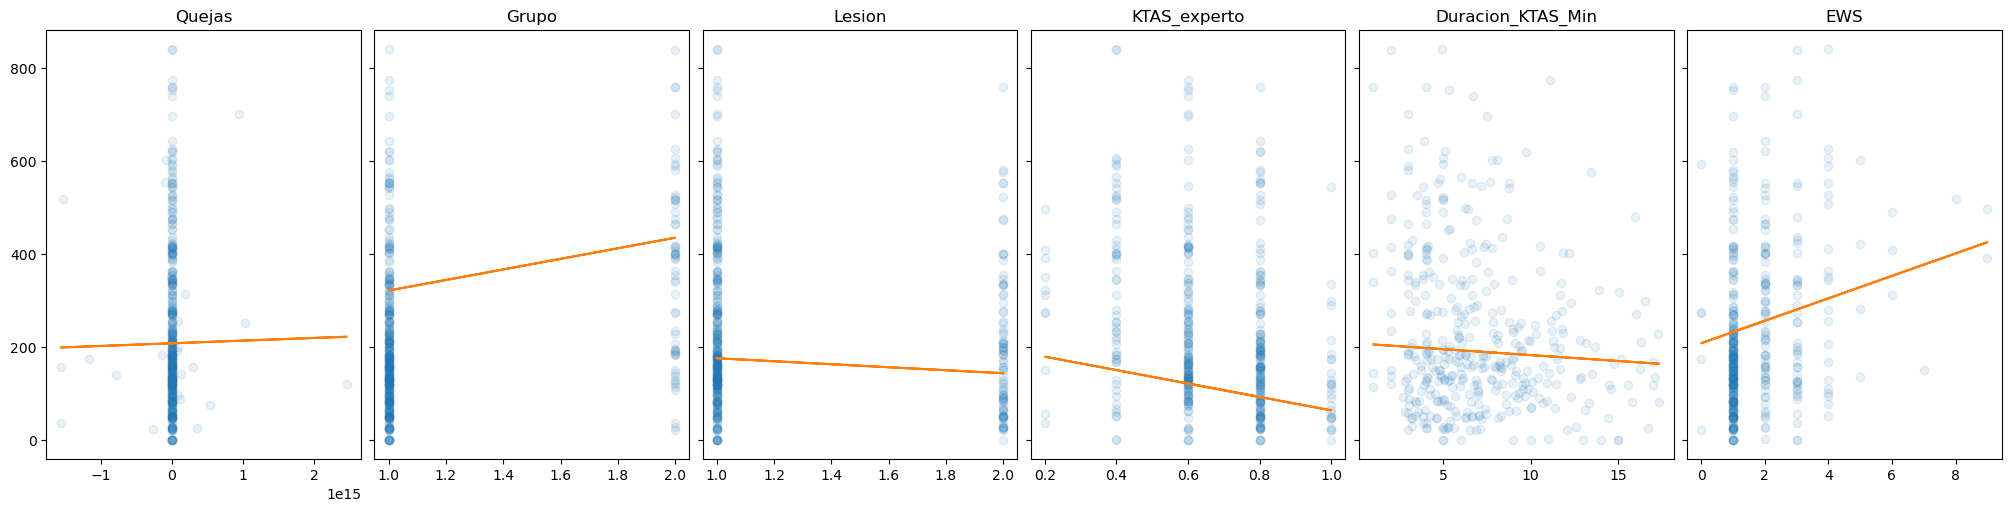

In [1108]:

X_train, X_test, y_train, y_test = train_test_split(datos[nuevo], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas+["Quejas"], "coef": regression.coef_})
f, axs = plt.subplots(1, len(nuevo), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(nuevo)):
    col = nuevo[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

<Axes: >

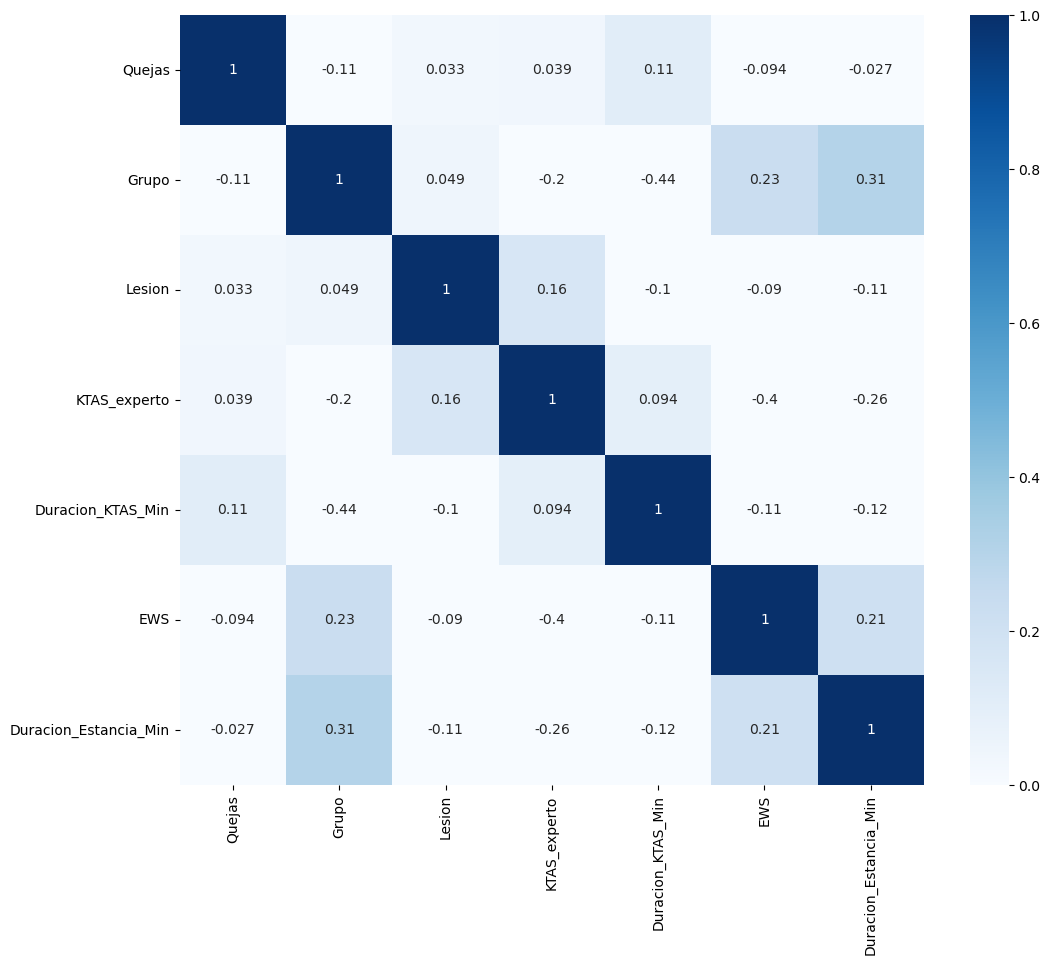

In [1109]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[nuevo+["Duracion_Estancia_Min"]].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)